In [1]:
from multiclass import ECOC
from sklearn import svm
from sklearn import tree
import pandas as pd

In [5]:
#read dataset
df = pd.read_csv('../data/train_data.csv')
X = (df.iloc[:,0:-2]).values
y = (df.iloc[:,-1]).values
df_test = pd.read_csv('../data/train_data.csv')
X_test = (df_test.iloc[:,0:-2]).values


# Decision Tree Classifier

In [24]:
clf = tree.DecisionTreeClassifier()
oECOC = ECOC(clf)
oECOC.estimator.fit(X,y)

df_test = pd.read_csv('../data/train_data.csv')
X_test = (df_test.iloc[:,0:-2]).values
X_test.shape

oECOC.estimator.predict_proba(X_test)

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

[Text(200.88000000000002, 181.2, 'X[1] <= 6.5\ngini = 0.515\nsamples = 1000\nvalue = [113, 245, 642]'),
 Text(133.92000000000002, 108.72, 'X[1] <= 3.5\ngini = 0.432\nsamples = 358\nvalue = [113, 245, 0]'),
 Text(66.96000000000001, 36.23999999999998, 'gini = 0.0\nsamples = 113\nvalue = [113, 0, 0]'),
 Text(200.88000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 245\nvalue = [0, 245, 0]'),
 Text(267.84000000000003, 108.72, 'gini = 0.0\nsamples = 642\nvalue = [0, 0, 642]')]

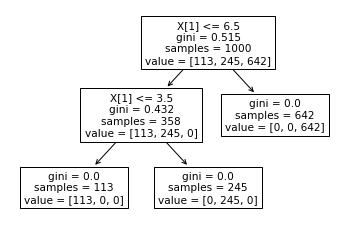

In [25]:
tree.plot_tree(clf.fit(X,y)) 